# Environment Setup

In [1]:
import time
import numpy as np
import pandas as pd
#pd.options.display.max_columns = None
#pd.options.display.mpl_style = 'default'

import re
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import sparse

## Import raw data
* Dataset link: https://biendata.com/competition/zhihu/data/

In [ ]:
t_0 = time.time()

df_train = pd.read_csv('data\question_train_set.txt', sep="\t", header = None, names = ['question_id', 'title_char_id','title_word_id','desc_char_id','desc_word_id'])
df_train_topic = pd.read_csv('data\question_topic_train_set.txt', sep="\t", header = None, names=['question_id', 'topic'])

df_train = pd.merge(df_train, df_train_topic, how='left', on='question_id')
# some of the title char/word are empty， here I removed all the questions which have NAN word title
df_train = df_train[df_train['title_word_id'].notnull()]

print('loading time: ',time.time() - t_0)

In [158]:
t_0 = time.time()

df_train['title_char_len'] = df_train['title_char_id'].map(lambda x: len(x.split(',')) if type(x) != float else 0)
df_train['title_word_len'] = df_train['title_word_id'].map(lambda x: len(x.split(',')) if type(x) != float else 0)
df_train['desc_char_len'] = df_train['desc_char_id'].map(lambda x: len(x.split(',')) if type(x) != float else 0)
df_train['desc_word_len'] = df_train['desc_word_id'].map(lambda x: len(x.split(',')) if type(x) != float else 0)

print('time: ',time.time() - t_0)

time:  95.96876549720764


C:\Users\zcakz\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


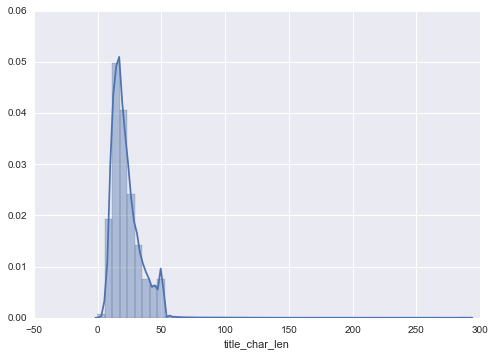

In [8]:
sns.distplot(df_train['title_char_len'])

C:\Users\zcakz\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


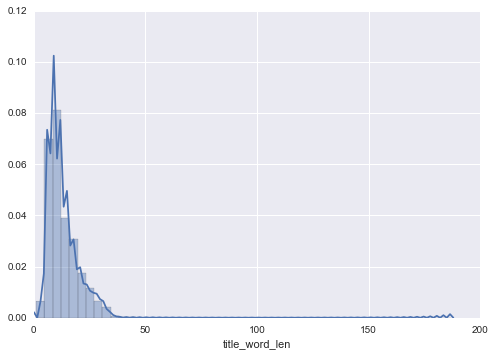

In [159]:
sns.distplot(df_train['title_word_len'])

C:\Users\zcakz\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


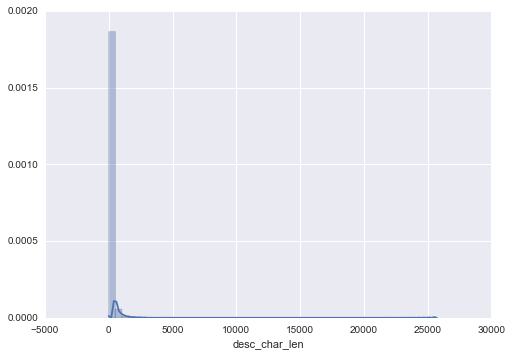

In [10]:
sns.distplot(df_train['desc_char_len'])

C:\Users\zcakz\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


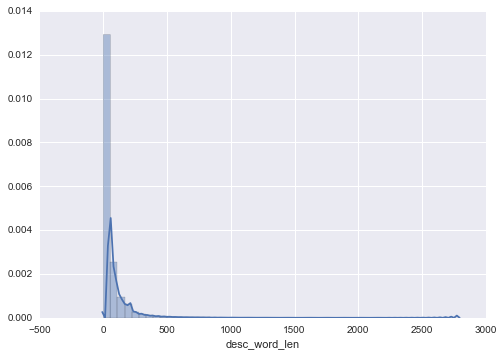

In [11]:
sns.distplot(df_train['desc_word_len'])

In [12]:
df_eval = pd.read_csv('data\question_eval_set.txt', sep="\t", header = None, names = ['question_id', 'title_char_id','title_word_id','desc_char_id','desc_word_id'])

In [13]:
df_eval['title_char_len'] = df_eval['title_char_id'].map(lambda x: len(x.split(',')) if type(x) != float else 0)
df_eval['title_word_len'] = df_eval['title_word_id'].map(lambda x: len(x.split(',')) if type(x) != float else 0)
df_eval['desc_char_len'] = df_eval['desc_char_id'].map(lambda x: len(x.split(',')) if type(x) != float else 0)
df_eval['desc_word_len'] = df_eval['desc_word_id'].map(lambda x: len(x.split(',')) if type(x) != float else 0)

C:\Users\zcakz\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


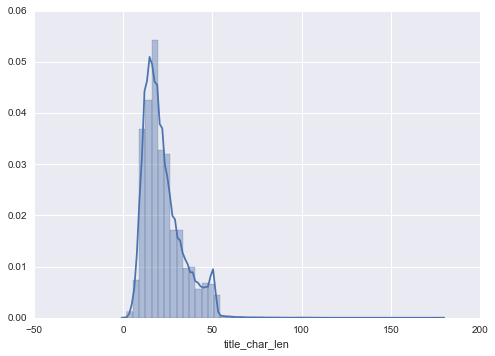

In [14]:
sns.distplot(df_eval['title_char_len'])

C:\Users\zcakz\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


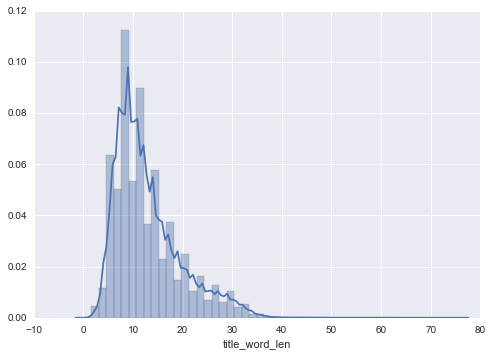

In [15]:
sns.distplot(df_eval['title_word_len'])

C:\Users\zcakz\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


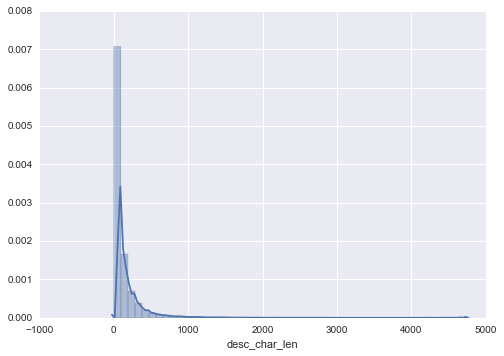

In [16]:
sns.distplot(df_eval['desc_char_len'])

C:\Users\zcakz\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


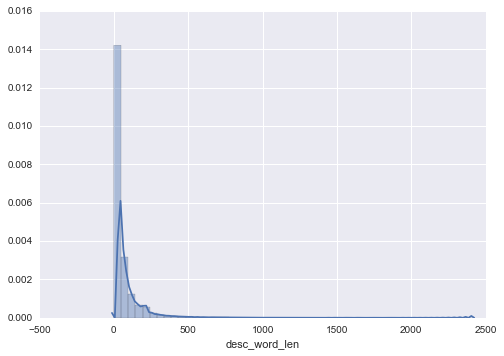

In [17]:
sns.distplot(df_eval['desc_word_len'])

In [168]:
def data_transform(file):
    data = []
    length = len(file)
    title_char = file['title_char_id'].values
    title_word = file['title_word_id'].values
    for i in range(length):
        instance = {"title_char": title_char[i], "title_word": title_word[i]}
        data.append(instance)
    return data

In [216]:
train = data_transform(df_train)

In [220]:
def title_word_pipeline(data, max_sent_len=50):
    
    out_sentences = np.full([len(data),  max_sent_len], 0, dtype=np.int32)
    for i,instance in enumerate(data):
        sentence = instance['title_word']
        if pd.isnull(sentence):
            sents = [0]
        else:
            sents=  re.sub("[w]", "", sentence)
            sents = eval(sents) 
            if type(sents) == int: 
                sents = [sents]
        if len(sents) <= max_sent_len:
            out_sentences[i, 0:len(sents)] = sents
        else:
            out_sentences[i, 0: max_sent_len] = sents[:max_sent_len]

    return out_sentences

def title_char_pipeline(data, max_sent_len=50):
    
    out_sentences = np.full([len(data),  max_sent_len], 0, dtype=np.int32)
    for i,instance in enumerate(data):
        sentence = instance['title_char']
        if pd.isnull(sentence):
            sents = [0]
        else:
            sents=  re.sub("[c]", "", sentence)
            sents = eval(sents) 
            if type(sents) == int: 
                sents = [sents]
        if len(sents) <= max_sent_len:
            out_sentences[i, 0:len(sents)] = sents
        else:
            out_sentences[i, 0: max_sent_len] = sents[:max_sent_len]

    return out_sentences

In [314]:
t_0 = time.time()

train_word = title_word_pipeline(train)
train_char = title_char_pipeline(train)

print('loading time: ',time.time() - t_0)

loading time:  491.1195719242096


### Char/Word Embedding

In [306]:
import collections
import operator
import random

t_0 = time.time()
word_dict= collections.defaultdict(list)
file= open('data/char_embedding.txt', 'r', encoding='utf-8')

for line in file:
    line = line.rstrip().split(' ')
    word_dict[line[0]]=[float(i) for i in line[1:]]
word_dict=dict(word_dict)

embedding_list=[]
OOV_vector  = [random.uniform(-0.5, 0.5) for i in range(256)]
for i in range(11973):
    if i == 0:
        embedding_list.append(np.array([0 for i in range(256)], dtype='f'))
    elif 'c%d' % i in word_dict:
        embedding_list.append(word_dict['c%d' % i])
    else:
        embedding_list.append(OOV_vector)
        
C = np.array(embedding_list)
print('loading time: ',time.time() - t_0)

loading time:  6.077656984329224


In [307]:
t_0 = time.time()
word_dict= collections.defaultdict(list)
file= open('data/word_embedding.txt', 'r', encoding='utf-8')

for line in file:
    line = line.rstrip().split(' ')
    word_dict[line[0]]=[float(i) for i in line[1:]]
word_dict=dict(word_dict)

embedding_list=[]
OOV_vector  = [random.uniform(-0.5, 0.5) for i in range(256)]
for i in range(411720):
    if i == 0:
        embedding_list.append(np.array([0 for i in range(256)], dtype='f'))
    elif 'w%d' % i in word_dict:
        embedding_list.append(word_dict['w%d' % i])
    else:
        embedding_list.append(OOV_vector)
       
W = np.array(embedding_list)
print('loading time: ',time.time() - t_0)

loading time:  58.54924917221069


### Topics Encoder

In [19]:
topic = pd.read_csv('topic.txt', sep="\t", header = None,\
                    names=['topic_id', 'parents_id','title_char_id','title_word_id','desc_char_id','desc_word_id'])

In [33]:
df_train_topic['topic'].values[0]

'7739004195693774975,3738968195649774859'

In [1]:
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
label_encoder.fit(list(topic['topic_id'].values))
label_encoder.transform(eval(df_train_topic['topic'].values[5])) 

NameError: name 'topic' is not defined